# BT4012 Kaggle Competition

Author: Loh Hong Tak Edmund

Python Version: 3.8.11

# plan:

- EDA
- Train-Test Split
- Oversampling 
    - SMOTE-EN
    - ADASYN
    - BorderlineSMOTE
    - SVMSMOTE
- Neural Networks
    - Vanila NN
    - CNN (3 layer)
    - CNN (5 layer)
- Ensemble Methods
    - XGBoost
    - RandomForest
    - Logistic Regression
    - MNB

## Importing packages

In [6]:
!pip install xgboost

  Using cached xgboost-1.4.2-py3-none-win_amd64.whl (97.8 MB)


In [1]:
# Loading Packages

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from numpy import sort
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, log_loss, roc_auc_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import xgboost

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

# Settings
import pickle
import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
def getRFEfeatures(model, x, y, n_features_to_select):
    rfe = RFE(model, n_features_to_select)
    rfe = rfe.fit(x,y)
    selected_features = list(x.columns[rfe.support_])
    print('Selected features: %s' % selected_features)
    return selected_features

def get_auc(model, x, y):
    y_pred_proba = model.predict_proba(x)[:,1]
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)
    return auc(fpr, tpr)

def get_logloss(model, x, y):
    y_pred_proba = model.predict_proba(x)[:,1]
    return log_loss(y, y_pred_proba)

def print_train_score(model, x_train, y_train, auc=True):
    pred = model.predict(x_train)
    model_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
    print("TRAIN RESULT:\n================================================")
    print(f"ACCURACY SCORE: {accuracy_score(y_train, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{model_report}")
    print("_______________________________________________")
    print(f"CONFUSION MATRIX: \n {confusion_matrix(y_train, pred)}\n")
    if auc:
        print("_______________________________________________")
        print(f"AUC Score: \n {get_auc(model, x_train, y_train)}\n")
    
def print_test_score(model, x_test, y_test, auc=True):
    pred = model.predict(x_test)
    model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
    print("TEST RESULT:\n================================================")
    print(f"ACCURACY SCORE: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{model_report}")
    print("_______________________________________________")
    print(f"CONFUSION MATRIX: \n {confusion_matrix(y_test, pred)}\n")
    if auc:
        print("_______________________________________________")
        print(f"AUC Score: \n {get_auc(model, x_test, y_test)}\n")

def predict_to_csv(model,ds,name):
    pred = model.predict(ds)
    pred_df = pd.DataFrame({'Id':Id, 'Predicted':pred}, columns=['Id', 'Predicted'])
    pred_df.to_csv('%s.csv'%(name), index=False)
    return True

## Loading Dataset

In [3]:
ds = pd.read_csv('train.csv')
ds = ds.drop_duplicates()

In [5]:
ds.head()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
0,1,1,1,1,28,43,52,255,255,255,...,191,255,52,34,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,128,255,255,255,255,255,255,255,...,255,255,255,255,255,255,128,1,1,0
3,53,54,61,91,141,172,197,223,233,246,...,184,185,187,169,147,106,82,34,23,1
4,46,46,46,46,36,36,41,41,41,41,...,38,65,65,95,95,149,149,205,205,0


In [4]:
ds.label

0        0
1        0
2        0
3        1
4        0
        ..
72134    0
72135    0
72136    0
72137    0
72138    0
Name: label, Length: 71967, dtype: int64

In [6]:
counter = Counter
counter(ds.label)

Counter({0: 65581, 1: 6558})

In [7]:
ds.describe()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
count,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,...,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000
mean,36.125383,51.473308,70.855279,82.032354,86.869142,96.391730,101.608728,108.712333,115.257752,119.014680,...,105.187416,101.996327,98.175689,94.994663,83.791611,79.024744,67.467084,49.497775,37.186349,0.090908
std,70.769428,83.545299,93.468985,99.787787,100.295541,103.128587,104.129642,103.806258,106.480366,107.572306,...,106.387324,102.402083,103.242319,102.317456,98.440790,97.781003,90.884177,82.706445,72.454911,0.287480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,18.000000,33.000000,52.000000,67.000000,91.000000,96.000000,104.000000,...,69.000000,73.000000,60.000000,52.000000,26.000000,7.000000,1.000000,1.000000,1.000000,0.000000
75%,30.000000,80.000000,128.000000,171.000000,181.000000,208.000000,219.000000,226.000000,248.000000,255.000000,...,236.000000,213.000000,207.000000,199.000000,172.000000,163.000000,128.000000,73.000000,24.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


In [4]:
X = ds.drop('label', axis=1)
y = ds.label.values


In [6]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, test_size=0.10,random_state=42)
x_train = x_train/255
x_val = x_val/255
x_test= x_test/255


In [17]:
Counter(y_test)

Counter({0: 13070, 1: 1324})

In [27]:
from imblearn.combine import SMOTEENN
x_train_smenn, y_train_smenn = SMOTEENN().fit_resample(x_train,y_train)

In [28]:
from imblearn.combine import SMOTETomek
x_train_tomek, y_train_tomek = SMOTETomek().fit_resample(x_train,y_train)

In [29]:
from imblearn.over_sampling import ADASYN
x_train_adasyn, y_train_adasyn = ADASYN().fit_resample(x_train, y_train)


In [30]:
from imblearn.over_sampling import BorderlineSMOTE
x_train_borderline, y_train_borderline = BorderlineSMOTE().fit_resample(x_train, y_train)


In [31]:
from imblearn.over_sampling import SVMSMOTE
x_train_svmsmote, y_train_svmsmote = SVMSMOTE().fit_resample(x_train, y_train)


In [39]:
from imblearn.over_sampling import RandomOverSampler
x_train_oversam, y_train_oversam = RandomOverSampler(random_state=42).fit_resample(x_train,y_train)

In [40]:
Counter(y_train_oversam)

Counter({0: 47196, 1: 47196})

In [12]:
def reshape_mat(X):
    X_mat = []
    for i in range(X.shape[0]):
        X_mat.append(np.reshape(X.iloc[i].tolist(), (20,20)).T)
    X_mat_arr = np.array(X_mat)
    X_mat_arr_ex = X_mat_arr[:,:,:,None]
    return X_mat_arr_ex

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    r = reshape_mat(image_batch)
    for n in range(100):
        ax = plt.subplot(10,10,n+1)
        plt.imshow(r[n])
        plt.title(str(label_batch[n]))
        plt.axis("off")

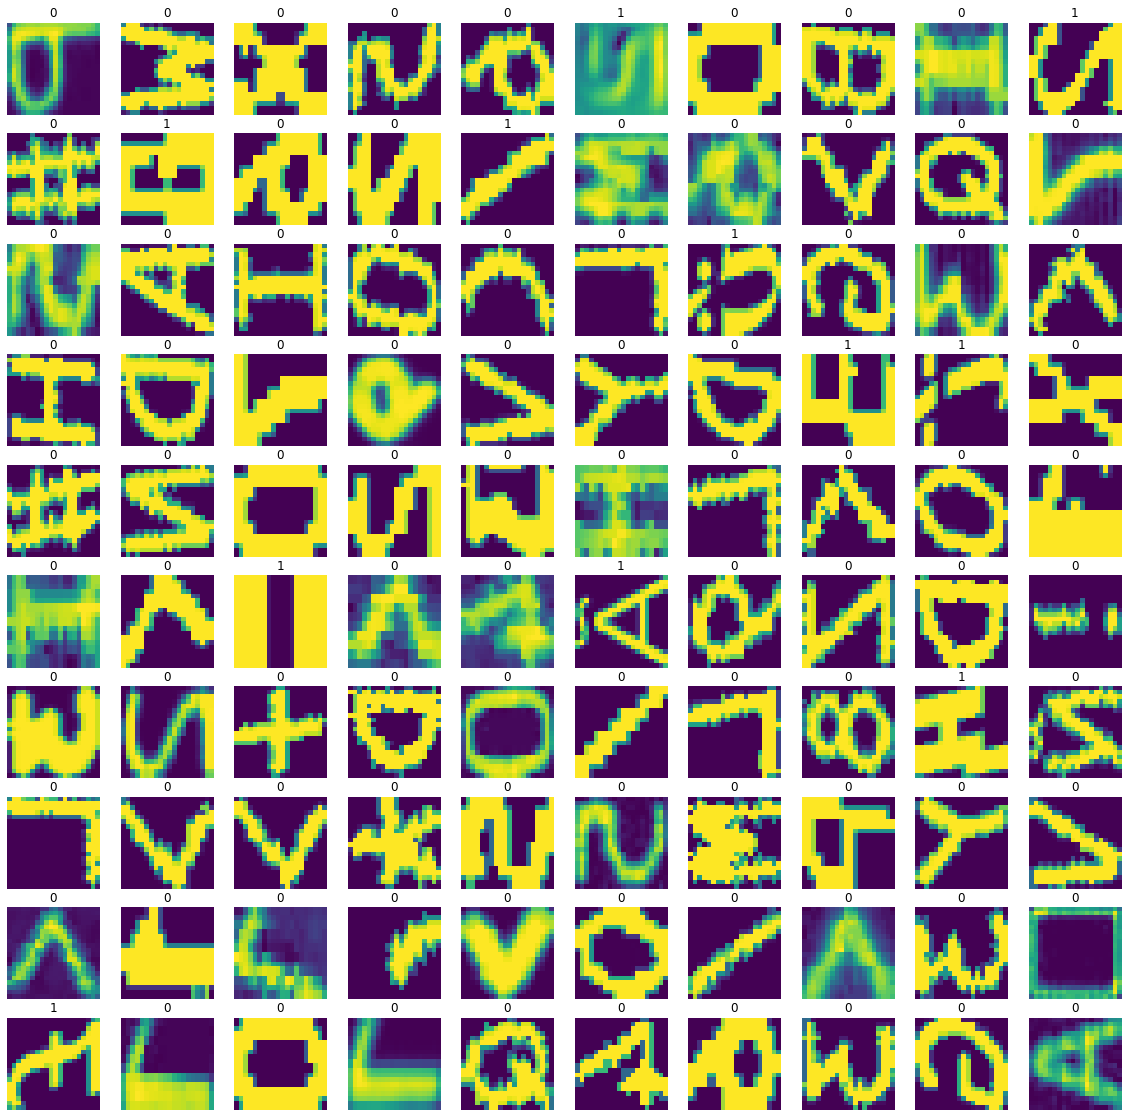

In [13]:
show_batch(x_train, y_train)


## CNNs

In [5]:
#model

def model_score(model, x, y):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Recall', 'Precision']
    )

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=12, restore_best_weights=True)]
    
    print("\n MODEL BUILDING ============================================================================ \n")

    history = model.fit(
        x, y, 
        epochs=128, 
        batch_size = 32, 
        validation_data=(x_val,y_val),
        callbacks=callbacks
    )

    print("\n MODEL EVALUATION ON TEST SET ============================================================================ \n")

    score = model.evaluate(x_test, y_test, batch_size=32)

    return [model, history, score]


def pred_test_to_csv(model, name):
    test_ds = pd.read_csv("test.csv")
    Id = test_ds['Id'][:]
    test_ds = test_ds.drop("Id", axis=1)
    test_ds = test_ds/255
    pred = model.predict(test_ds)
    pred_df = pd.DataFrame({'Id':Id.values, 'Predicted':pred.flatten()}, columns=['Id', 'Predicted'])
    print(pred_df)
    pred_df.to_csv(f'{name}.csv', index=False)
    return True

In [8]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, (3, 3), activation = 'relu', padding='same', kernel_regularizer=l2(0.0001)),
        tf.keras.layers.Conv2D(filters, (3, 3), activation = 'relu', padding='same', kernel_regularizer=l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')
    ])
    return block

def conv_layer(filters):
    return tf.keras.Sequential([layers.Conv2D(filters, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same')])

def pool_layer(size):
    return tf.keras.Sequential([layers.MaxPooling2D(pool_size=(size, size), strides=(2, 2), padding='same')])

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

# CNN (4-layers) with SMOTE-ENN

In [32]:
# predictions_CNN_prob_1 - SUBMIT THISISSISISISISISISIS
#  0.98813

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    #layers.InputLayer(input_shape=(20, 20, 1)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_1 = model_score(model, x_train_smenn, y_train_smenn)

Epoch 1/32
2888/2888 [==============================] - 93s 32ms/step - loss: 0.2734 - accuracy: 0.8899 - auc: 0.9593 - recall: 0.8876 - precision: 0.8959 - val_loss: 0.2019 - val_accuracy: 0.9340 - val_auc: 0.9749 - val_recall: 0.9179 - val_precision: 0.5935
Epoch 2/32
2888/2888 [==============================] - 124s 43ms/step - loss: 0.1327 - accuracy: 0.9571 - auc: 0.9912 - recall: 0.9601 - precision: 0.9561 - val_loss: 0.1529 - val_accuracy: 0.9534 - val_auc: 0.9798 - val_recall: 0.9104 - val_precision: 0.6883
Epoch 3/32
2888/2888 [==============================] - 145s 50ms/step - loss: 0.1060 - accuracy: 0.9680 - auc: 0.9948 - recall: 0.9719 - precision: 0.9657 - val_loss: 0.1655 - val_accuracy: 0.9525 - val_auc: 0.9656 - val_recall: 0.8358 - val_precision: 0.7066
Epoch 4/32
2888/2888 [==============================] - 162s 56ms/step - loss: 0.0891 - accuracy: 0.9750 - auc: 0.9967 - recall: 0.9780 - precision: 0.9732 - val_loss: 0.1625 - val_accuracy: 0.9569 - val_auc: 0.9806 - 

In [39]:
# predictions_CNN_prob_2 
# SMOTE EN sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    #layers.InputLayer(input_shape=(20, 20, 1)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_2 = model_score(model, x_train_smenn, y_train_smenn)


 MODEL BUILDING ============================================================================ 

Epoch 1/32
2888/2888 [==============================] - 170s 58ms/step - loss: 0.4688 - accuracy: 0.7657 - auc: 0.8603 - recall: 0.7909 - precision: 0.7601 - val_loss: 0.2494 - val_accuracy: 0.9092 - val_auc: 0.8979 - val_recall: 0.6903 - val_precision: 0.5082
Epoch 2/32
2888/2888 [==============================] - 155s 54ms/step - loss: 0.2901 - accuracy: 0.8858 - auc: 0.9513 - recall: 0.8869 - precision: 0.8891 - val_loss: 0.2143 - val_accuracy: 0.9165 - val_auc: 0.9375 - val_recall: 0.7985 - val_precision: 0.5337
Epoch 3/32
2888/2888 [==============================] - 159s 55ms/step - loss: 0.2420 - accuracy: 0.9090 - auc: 0.9668 - recall: 0.9115 - precision: 0.9105 - val_loss: 0.2316 - val_accuracy: 0.9092 - val_auc: 0.9390 - val_recall: 0.8022 - val_precision: 0.5071
Epoch 4/32
2888/2888 [==============================] - 168s 58ms/step - loss: 0.2168 - accuracy: 0.9213 - auc: 0.9741 - 

In [40]:
# 5-layer on normally sampled train set.
# predictions_CNN_prob_3 - SUBMIT THISISSISISISISISISIS
# 0.99060 on kaggle
# normally sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    #layers.InputLayer(input_shape=(20, 20, 1)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_3 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/32
1624/1624 [==============================] - 93s 56ms/step - loss: 0.2617 - accuracy: 0.9210 - auc: 0.7793 - recall: 0.1982 - precision: 0.7438 - val_loss: 0.2422 - val_accuracy: 0.9397 - val_auc: 0.9067 - val_recall: 0.4944 - val_precision: 0.7749
Epoch 2/32
1624/1624 [==============================] - 100s 62ms/step - loss: 0.1812 - accuracy: 0.9435 - auc: 0.9053 - recall: 0.4986 - precision: 0.8044 - val_loss: 0.1912 - val_accuracy: 0.9494 - val_auc: 0.9451 - val_recall: 0.5634 - val_precision: 0.8389
Epoch 3/32
1624/1624 [==============================] - 91s 56ms/step - loss: 0.1584 - accuracy: 0.9493 - auc: 0.9349 - recall: 0.5720 - precision: 0.8141 - val_loss: 0.1366 - val_accuracy: 0.9572 - val_auc: 0.9592 - val_recall: 0.6828 - val_precision: 0.8262
Epoch 4/32
1624/1624 [==============================] - 90s 56ms/step - loss: 0.1436 - accuracy: 0.9546 - auc: 0.9497 - rec

In [48]:
model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    #keras.layers.InputLayer(input_shape=(20, 20, 1)),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    conv_block(256),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_CNN_4 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/64
1624/1624 [==============================] - 167s 101ms/step - loss: 0.4036 - accuracy: 0.9200 - auc: 0.7902 - recall: 0.2610 - precision: 0.6482 - val_loss: 0.4930 - val_accuracy: 0.8820 - val_auc: 0.8621 - val_recall: 0.6493 - val_precision: 0.4138
Epoch 2/64
1624/1624 [==============================] - 156s 96ms/step - loss: 0.2805 - accuracy: 0.9348 - auc: 0.8776 - recall: 0.4469 - precision: 0.7302 - val_loss: 0.6525 - val_accuracy: 0.5035 - val_auc: 0.8335 - val_recall: 0.9627 - val_precision: 0.1535
Epoch 3/64
1624/1624 [==============================] - 151s 93ms/step - loss: 0.2445 - accuracy: 0.9364 - auc: 0.8879 - recall: 0.4861 - precision: 0.7224 - val_loss: 0.2242 - val_accuracy: 0.9390 - val_auc: 0.9155 - val_recall: 0.6343 - val_precision: 0.6855
Epoch 4/64
1624/1624 [==============================] - 153s 94ms/step - loss: 0.2495 - accuracy: 0.9325 - auc: 0.8813 -

In [66]:
# 5-layer on normally sampled train set.
# predictions_CNN_prob_6 
# normally sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(96, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_6 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1624/1624 [==============================] - 29s 17ms/step - loss: 0.1688 - accuracy: 0.9479 - auc: 0.9219 - recall: 0.5610 - precision: 0.8138 - val_loss: 0.1664 - val_accuracy: 0.9574 - val_auc: 0.9582 - val_recall: 0.7167 - val_precision: 0.7954
Epoch 2/128
1624/1624 [==============================] - 30s 19ms/step - loss: 0.1108 - accuracy: 0.9655 - auc: 0.9712 - recall: 0.7255 - precision: 0.8775 - val_loss: 0.1071 - val_accuracy: 0.9683 - val_auc: 0.9720 - val_recall: 0.7605 - val_precision: 0.8753
Epoch 3/128
1624/1624 [==============================] - 32s 20ms/step - loss: 0.0924 - accuracy: 0.9729 - auc: 0.9810 - recall: 0.7869 - precision: 0.9054 - val_loss: 0.1032 - val_accuracy: 0.9747 - val_auc: 0.9829 - val_recall: 0.7643 - val_precision: 0.9481
Epoch 4/128
1624/1624 [==============================] - 33s 20ms/step - loss: 0.0808 - accuracy: 0.9778 - auc: 0.9859 - 

In [69]:
# 5-layer on normally sampled train set. => to submit
# predictions_CNN_prob_7
# normally sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_7 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1624/1624 [==============================] - 29s 17ms/step - loss: 0.1820 - accuracy: 0.9436 - auc: 0.9062 - recall: 0.5161 - precision: 0.7870 - val_loss: 0.1933 - val_accuracy: 0.9589 - val_auc: 0.9688 - val_recall: 0.6736 - val_precision: 0.8480
Epoch 2/128
1624/1624 [==============================] - 29s 18ms/step - loss: 0.1162 - accuracy: 0.9647 - auc: 0.9660 - recall: 0.7164 - precision: 0.8704 - val_loss: 0.1910 - val_accuracy: 0.9674 - val_auc: 0.9828 - val_recall: 0.8566 - val_precision: 0.8021
Epoch 3/128
1624/1624 [==============================] - 30s 18ms/step - loss: 0.0971 - accuracy: 0.9713 - auc: 0.9779 - recall: 0.7686 - precision: 0.8989 - val_loss: 0.1558 - val_accuracy: 0.9556 - val_auc: 0.9654 - val_recall: 0.6962 - val_precision: 0.7953
Epoch 4/128
1624/1624 [==============================] - 32s 20ms/step - loss: 0.0847 - accuracy: 0.9759 - auc: 0.9849 - 

In [70]:
pred_test_to_csv(model_CNN_7[0], "predictions_CNN_prob_7")

          Id     Predicted
0          0  8.565439e-06
1          1  6.351068e-05
2          2  2.352402e-05
3          3  2.126926e-09
4          4  1.668296e-07
...      ...           ...
30912  30912  1.296144e-04
30913  30913  3.701574e-03
30914  30914  2.170700e-01
30915  30915  8.016825e-06
30916  30916  2.035295e-06

[30917 rows x 2 columns]


True

In [74]:
# 5-layer on normally sampled train set. ===> submit
# predictions_CNN_prob_8
# normally sampled
#  0.99076


model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_8 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1624/1624 [==============================] - 30s 17ms/step - loss: 0.2661 - accuracy: 0.9128 - auc: 0.8316 - recall: 0.2470 - precision: 0.5385 - val_loss: 0.2039 - val_accuracy: 0.9463 - val_auc: 0.9604 - val_recall: 0.4736 - val_precision: 0.8901
Epoch 2/128
1624/1624 [==============================] - 30s 19ms/step - loss: 0.1632 - accuracy: 0.9481 - auc: 0.9397 - recall: 0.5320 - precision: 0.8336 - val_loss: 0.2349 - val_accuracy: 0.9612 - val_auc: 0.9686 - val_recall: 0.7472 - val_precision: 0.8148
Epoch 3/128
1624/1624 [==============================] - 35s 22ms/step - loss: 0.1337 - accuracy: 0.9596 - auc: 0.9597 - recall: 0.6445 - precision: 0.8759 - val_loss: 0.1656 - val_accuracy: 0.9633 - val_auc: 0.9681 - val_recall: 0.6887 - val_precision: 0.8859
Epoch 4/128
1624/1624 [==============================] - 35s 22ms/step - loss: 0.1103 - accuracy: 0.9685 - auc: 0.9749 - 

In [75]:
pred_test_to_csv(model_CNN_8[0], "predictions_CNN_prob_8")

          Id     Predicted
0          0  9.057642e-07
1          1  5.331922e-02
2          2  1.952135e-04
3          3  2.256034e-07
4          4  3.165077e-06
...      ...           ...
30912  30912  3.877303e-04
30913  30913  2.209523e-03
30914  30914  2.677908e-01
30915  30915  1.394543e-02
30916  30916  1.163967e-05

[30917 rows x 2 columns]


True

In [81]:
# 5-layer on normally sampled train set. ===> submit
# predictions_CNN_prob_9
# normally sampled
#  Kaggle: 0.99249


model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_9 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1624/1624 [==============================] - 28s 16ms/step - loss: 0.1820 - accuracy: 0.9433 - auc: 0.9088 - recall: 0.4941 - precision: 0.8031 - val_loss: 0.1577 - val_accuracy: 0.9451 - val_auc: 0.9552 - val_recall: 0.4377 - val_precision: 0.9243
Epoch 2/128
1624/1624 [==============================] - 27s 16ms/step - loss: 0.1187 - accuracy: 0.9649 - auc: 0.9636 - recall: 0.7081 - precision: 0.8808 - val_loss: 0.1085 - val_accuracy: 0.9660 - val_auc: 0.9758 - val_recall: 0.7434 - val_precision: 0.8678
Epoch 3/128
1624/1624 [==============================] - 28s 17ms/step - loss: 0.0983 - accuracy: 0.9717 - auc: 0.9778 - recall: 0.7701 - precision: 0.9024 - val_loss: 0.0996 - val_accuracy: 0.9655 - val_auc: 0.9836 - val_recall: 0.6660 - val_precision: 0.9413
Epoch 4/128
1624/1624 [==============================] - 29s 18ms/step - loss: 0.0877 - accuracy: 0.9766 - auc: 0.9833 - 

In [82]:
pred_test_to_csv(model_CNN_9[0], "predictions_CNN_prob_9")

          Id     Predicted
0          0  4.721542e-06
1          1  8.080629e-03
2          2  3.323448e-07
3          3  5.033775e-09
4          4  1.272920e-08
...      ...           ...
30912  30912  2.600307e-05
30913  30913  1.119968e-02
30914  30914  2.807036e-01
30915  30915  9.110881e-10
30916  30916  4.104823e-08

[30917 rows x 2 columns]


True

In [54]:
# 5-layer on normally sampled train set. 
# predictions_CNN_prob_10
# adasyn sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_10 = model_score(model, x_train_adasyn, y_train_adasyn)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2954/2954 [==============================] - 63s 21ms/step - loss: 0.2408 - accuracy: 0.9091 - auc: 0.9677 - recall: 0.9155 - precision: 0.9041 - val_loss: 0.1265 - val_accuracy: 0.9596 - val_auc: 0.9703 - val_recall: 0.8000 - val_precision: 0.7786
Epoch 2/128
2954/2954 [==============================] - 65s 22ms/step - loss: 0.1121 - accuracy: 0.9669 - auc: 0.9932 - recall: 0.9740 - precision: 0.9604 - val_loss: 0.1452 - val_accuracy: 0.9520 - val_auc: 0.9742 - val_recall: 0.8844 - val_precision: 0.6925
Epoch 3/128
2954/2954 [==============================] - 62s 21ms/step - loss: 0.0858 - accuracy: 0.9791 - auc: 0.9966 - recall: 0.9842 - precision: 0.9744 - val_loss: 0.1323 - val_accuracy: 0.9629 - val_auc: 0.9699 - val_recall: 0.8752 - val_precision: 0.7657
Epoch 4/128
2954/2954 [==============================] - 56s 19ms/step - loss: 0.0756 - accuracy: 0.9844 - auc: 0.9977 - 

In [35]:
# 5-layer on normally sampled train set. 
# predictions_CNN_prob_11
# borderline sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_11 = model_score(model, x_train_borderline, y_train_borderline)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2950/2950 [==============================] - 59s 20ms/step - loss: 0.2203 - accuracy: 0.9206 - auc: 0.9730 - recall: 0.9299 - precision: 0.9128 - val_loss: 0.1348 - val_accuracy: 0.9548 - val_auc: 0.9692 - val_recall: 0.7688 - val_precision: 0.7563
Epoch 2/128
2950/2950 [==============================] - 58s 20ms/step - loss: 0.1031 - accuracy: 0.9718 - auc: 0.9942 - recall: 0.9769 - precision: 0.9670 - val_loss: 0.1425 - val_accuracy: 0.9591 - val_auc: 0.9657 - val_recall: 0.7284 - val_precision: 0.8186
Epoch 3/128
2950/2950 [==============================] - 56s 19ms/step - loss: 0.0822 - accuracy: 0.9811 - auc: 0.9969 - recall: 0.9847 - precision: 0.9777 - val_loss: 0.1169 - val_accuracy: 0.9678 - val_auc: 0.9759 - val_recall: 0.7927 - val_precision: 0.8554
Epoch 4/128
2950/2950 [==============================] - 57s 19ms/step - loss: 0.0707 - accuracy: 0.9869 - auc: 0.9981 - 

In [14]:
pred_test_to_csv(model_CNN_11[0], "predictions_CNN_prob_11")

          Id     Predicted
0          0  8.629061e-08
1          1  1.916419e-05
2          2  5.860349e-04
3          3  2.802911e-07
4          4  7.559953e-08
...      ...           ...
30912  30912  2.332528e-04
30913  30913  1.318149e-02
30914  30914  1.473697e-01
30915  30915  8.662563e-06
30916  30916  8.383747e-03

[30917 rows x 2 columns]


True

In [36]:
# 5-layer on normally sampled train set. 
# predictions_CNN_prob_12
# svm sampled
# 
#  
model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])
model_CNN_12 = model_score(model, x_train_svmsmote, y_train_svmsmote)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2950/2950 [==============================] - 60s 20ms/step - loss: 0.2020 - accuracy: 0.9265 - auc: 0.9775 - recall: 0.9234 - precision: 0.9291 - val_loss: 0.1181 - val_accuracy: 0.9622 - val_auc: 0.9772 - val_recall: 0.8349 - val_precision: 0.7804
Epoch 2/128
2950/2950 [==============================] - 57s 19ms/step - loss: 0.1017 - accuracy: 0.9701 - auc: 0.9948 - recall: 0.9726 - precision: 0.9677 - val_loss: 0.1255 - val_accuracy: 0.9662 - val_auc: 0.9782 - val_recall: 0.8385 - val_precision: 0.8103
Epoch 3/128
2950/2950 [==============================] - 61s 21ms/step - loss: 0.0837 - accuracy: 0.9798 - auc: 0.9970 - recall: 0.9816 - precision: 0.9781 - val_loss: 0.1262 - val_accuracy: 0.9622 - val_auc: 0.9744 - val_recall: 0.8569 - val_precision: 0.7694
Epoch 4/128
2950/2950 [==============================] - 55s 19ms/step - loss: 0.0753 - accuracy: 0.9840 - auc: 0.9980 - 

In [55]:
pred_test_to_csv(model_CNN_12[0], "predictions_CNN_prob_12")

          Id     Predicted
0          0  1.182344e-03
1          1  3.673962e-04
2          2  1.781049e-05
3          3  9.008203e-07
4          4  5.624769e-05
...      ...           ...
30912  30912  3.286622e-03
30913  30913  8.990210e-02
30914  30914  1.148125e-01
30915  30915  2.370128e-05
30916  30916  1.280994e-05

[30917 rows x 2 columns]


True

In [37]:
# 5-layer on normally sampled train set. 
# predictions_CNN_prob_13
# smotetomek sampled
# 
#  
model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])
model_CNN_13 = model_score(model, x_train_tomek, y_train_tomek)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2950/2950 [==============================] - 57s 19ms/step - loss: 0.2286 - accuracy: 0.9138 - auc: 0.9713 - recall: 0.9092 - precision: 0.9176 - val_loss: 0.3274 - val_accuracy: 0.9007 - val_auc: 0.9711 - val_recall: 0.9321 - val_precision: 0.4866
Epoch 2/128
2950/2950 [==============================] - 55s 19ms/step - loss: 0.1145 - accuracy: 0.9663 - auc: 0.9932 - recall: 0.9706 - precision: 0.9624 - val_loss: 0.1495 - val_accuracy: 0.9428 - val_auc: 0.9744 - val_recall: 0.8972 - val_precision: 0.6409
Epoch 3/128
2950/2950 [==============================] - 55s 19ms/step - loss: 0.0913 - accuracy: 0.9769 - auc: 0.9963 - recall: 0.9802 - precision: 0.9737 - val_loss: 0.1258 - val_accuracy: 0.9653 - val_auc: 0.9833 - val_recall: 0.8807 - val_precision: 0.7805
Epoch 4/128
2950/2950 [==============================] - 57s 19ms/step - loss: 0.0806 - accuracy: 0.9828 - auc: 0.9976 - 

In [18]:
# 5-layer on normally sampled train set. 
# predictions_CNN_prob_14
# smoteen sampled
# 
#  
model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])
model_CNN_14 = model_score(model, x_train_smenn, y_train_smenn)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2887/2887 [==============================] - 65s 22ms/step - loss: 0.2112 - accuracy: 0.9214 - auc: 0.9754 - recall: 0.9210 - precision: 0.9247 - val_loss: 0.1558 - val_accuracy: 0.9470 - val_auc: 0.9699 - val_recall: 0.8422 - val_precision: 0.6760
Epoch 2/128
2887/2887 [==============================] - 71s 24ms/step - loss: 0.0980 - accuracy: 0.9716 - auc: 0.9951 - recall: 0.9749 - precision: 0.9696 - val_loss: 0.1846 - val_accuracy: 0.9359 - val_auc: 0.9777 - val_recall: 0.9193 - val_precision: 0.6058
Epoch 3/128
2887/2887 [==============================] - 79s 27ms/step - loss: 0.0740 - accuracy: 0.9828 - auc: 0.9977 - recall: 0.9846 - precision: 0.9816 - val_loss: 0.2008 - val_accuracy: 0.9468 - val_auc: 0.9780 - val_recall: 0.9138 - val_precision: 0.6570
Epoch 4/128
2887/2887 [==============================] - 79s 28ms/step - loss: 0.0642 - accuracy: 0.9877 - auc: 0.9986 - 

In [44]:
# 5-layer on normally sampled train set. ===> submit
# predictions_CNN_prob_15
# random oversampled
# 


model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_15 = model_score(model, x_train_oversam, y_train_oversam)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2950/2950 [==============================] - 90s 30ms/step - loss: 0.2235 - accuracy: 0.9153 - auc: 0.9727 - recall: 0.9169 - precision: 0.9140 - val_loss: 0.1617 - val_accuracy: 0.9563 - val_auc: 0.9795 - val_recall: 0.8734 - val_precision: 0.7223
Epoch 2/128
2950/2950 [==============================] - 82s 28ms/step - loss: 0.1070 - accuracy: 0.9695 - auc: 0.9940 - recall: 0.9779 - precision: 0.9619 - val_loss: 0.1793 - val_accuracy: 0.9534 - val_auc: 0.9851 - val_recall: 0.9450 - val_precision: 0.6830
Epoch 3/128
2950/2950 [==============================] - 64s 22ms/step - loss: 0.0812 - accuracy: 0.9809 - auc: 0.9972 - recall: 0.9862 - precision: 0.9758 - val_loss: 0.1336 - val_accuracy: 0.9619 - val_auc: 0.9846 - val_recall: 0.9119 - val_precision: 0.7429
Epoch 4/128
2950/2950 [==============================] - 67s 23ms/step - loss: 0.0710 - accuracy: 0.9864 - auc: 0.9982 - 

In [45]:
pred_test_to_csv(model_CNN_15[0], "predictions_CNN_prob_15_2")

          Id  Predicted
0          0   0.000044
1          1   0.000160
2          2   0.027587
3          3   0.000024
4          4   0.003521
...      ...        ...
30912  30912   0.000028
30913  30913   0.584994
30914  30914   0.227613
30915  30915   0.002541
30916  30916   0.000012

[30917 rows x 2 columns]


True

In [52]:
# 4-layer on normally sampled train set. 
# predictions_CNN_prob_16
# random over sampled
#  

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.00001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.00001)),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_16 = model_score(model, x_train_oversam, y_train_oversam)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
2950/2950 [==============================] - 44s 14ms/step - loss: 0.2382 - accuracy: 0.9068 - auc: 0.9682 - recall: 0.9054 - precision: 0.9079 - val_loss: 0.1268 - val_accuracy: 0.9496 - val_auc: 0.9761 - val_recall: 0.8569 - val_precision: 0.6868
Epoch 2/128
2950/2950 [==============================] - 45s 15ms/step - loss: 0.1081 - accuracy: 0.9664 - auc: 0.9935 - recall: 0.9739 - precision: 0.9596 - val_loss: 0.1956 - val_accuracy: 0.9295 - val_auc: 0.9840 - val_recall: 0.9560 - val_precision: 0.5763
Epoch 3/128
2950/2950 [==============================] - 49s 16ms/step - loss: 0.0794 - accuracy: 0.9800 - auc: 0.9970 - recall: 0.9846 - precision: 0.9756 - val_loss: 0.1842 - val_accuracy: 0.9466 - val_auc: 0.9782 - val_recall: 0.9193 - val_precision: 0.6549
Epoch 4/128
2950/2950 [==============================] - 53s 18ms/step - loss: 0.0696 - accuracy: 0.9852 - auc: 0.9981 - 

In [53]:
pred_test_to_csv(model_CNN_16[0], "predictions_CNN_prob_16")

          Id     Predicted
0          0  1.243785e-11
1          1  6.365884e-06
2          2  9.675701e-10
3          3  4.006355e-08
4          4  1.434304e-04
...      ...           ...
30912  30912  1.194210e-06
30913  30913  2.830749e-05
30914  30914  5.575607e-01
30915  30915  3.342547e-06
30916  30916  1.045959e-05

[30917 rows x 2 columns]


True

In [28]:
# CNN model 17
# 5 layer CNN
# Normally Sampled

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    #layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dense(1, activation='sigmoid')
])

model_CNN_17 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1624/1624 [==============================] - 34s 20ms/step - loss: 0.1737 - accuracy: 0.9439 - auc: 0.9111 - recall: 0.5144 - precision: 0.7992 - val_loss: 0.1902 - val_accuracy: 0.9387 - val_auc: 0.9436 - val_recall: 0.3743 - val_precision: 0.9401
Epoch 2/128
1624/1624 [==============================] - 35s 21ms/step - loss: 0.1084 - accuracy: 0.9639 - auc: 0.9653 - recall: 0.7063 - precision: 0.8742 - val_loss: 0.1138 - val_accuracy: 0.9579 - val_auc: 0.9661 - val_recall: 0.5817 - val_precision: 0.9548
Epoch 3/128
1624/1624 [==============================] - 36s 22ms/step - loss: 0.0842 - accuracy: 0.9719 - auc: 0.9785 - recall: 0.7793 - precision: 0.9001 - val_loss: 0.0912 - val_accuracy: 0.9695 - val_auc: 0.9778 - val_recall: 0.7468 - val_precision: 0.9146
Epoch 4/128
1624/1624 [==============================] - 35s 22ms/step - loss: 0.0692 - accuracy: 0.9764 - auc: 0.9853 - 

In [29]:
pred_test_to_csv(model_CNN_17[0], "predictions_CNN_prob_17")

          Id     Predicted
0          0  1.504792e-07
1          1  1.609468e-03
2          2  7.392058e-04
3          3  6.585059e-07
4          4  2.530175e-05
...      ...           ...
30912  30912  6.021515e-03
30913  30913  2.532866e-02
30914  30914  6.700584e-02
30915  30915  2.512855e-04
30916  30916  3.985780e-06

[30917 rows x 2 columns]


True

In [13]:
# CNN model 18
# 5 layer CNN
# Normally Sampled

model = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dropout(0.6),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dropout(0.6),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.000001)),

    layers.Dense(1, activation='sigmoid')
])

model_CNN_19 = model_score(model, x_train, y_train)


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1624/1624 [==============================] - 36s 21ms/step - loss: 0.2069 - accuracy: 0.9327 - auc: 0.8844 - recall: 0.4113 - precision: 0.7346 - val_loss: 0.1286 - val_accuracy: 0.9556 - val_auc: 0.9617 - val_recall: 0.5908 - val_precision: 0.9070
Epoch 2/128
1624/1624 [==============================] - 38s 23ms/step - loss: 0.1221 - accuracy: 0.9611 - auc: 0.9591 - recall: 0.6880 - precision: 0.8576 - val_loss: 0.2117 - val_accuracy: 0.9650 - val_auc: 0.9742 - val_recall: 0.7339 - val_precision: 0.8753
Epoch 3/128
1624/1624 [==============================] - 37s 23ms/step - loss: 0.0951 - accuracy: 0.9696 - auc: 0.9736 - recall: 0.7487 - precision: 0.9015 - val_loss: 0.1211 - val_accuracy: 0.9581 - val_auc: 0.9791 - val_recall: 0.5615 - val_precision: 0.9903
Epoch 4/128
1624/1624 [==============================] - 39s 24ms/step - loss: 0.0804 - accuracy: 0.9736 - auc: 0.9814 - 

In [11]:
pred_test_to_csv(model_CNN_19[0], "predictions_CNN_prob_19_3")

          Id  Predicted
0          0   0.000036
1          1   0.004224
2          2   0.012739
3          3   0.000304
4          4   0.000064
...      ...        ...
30912  30912   0.006777
30913  30913   0.011279
30914  30914   0.257418
30915  30915   0.000593
30916  30916   0.038625

[30917 rows x 2 columns]


True

In [30]:
RANDOM_STATE = 6
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=RANDOM_STATE)
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, test_size=0.10,random_state=RANDOM_STATE)
x_train = x_train/255
x_val = x_val/255
x_test= x_test/255


In [ ]:
record ={}

In [11]:
# CNN model 20
# 5 layer CNN
# Normally Sampled
record3 ={}

for i in range(60,61):
    RANDOM_STATE = i
    x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=RANDOM_STATE)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, test_size=0.10,random_state=RANDOM_STATE)
    x_train = x_train/255
    x_val = x_val/255
    x_test= x_test/255


    model = tf.keras.Sequential([
        layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
        layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.000001)),
        layers.Dropout(0.6, seed=RANDOM_STATE),
        #layers.Dense(128, activation='relu', kernel_regularizer=l2(0.000001)),
        layers.Dense(16, activation='relu', kernel_regularizer=l2(0.000001)),
        #layers.Dense(32, activation='relu', kernel_regularizer=l2(0.000001)),
        #layers.Dense(16, activation='relu', kernel_regularizer=l2(0.000001)),
        layers.Dense(1, activation='sigmoid')
    ])

    model_CNN_20 = model_score(model, x_train, y_train)
    record3[RANDOM_STATE] = model_CNN_20


 MODEL BUILDING ============================================================================ 

Epoch 1/128
1620/1620 [==============================] - 31s 18ms/step - loss: 0.1783 - accuracy: 0.9409 - auc: 0.9066 - recall: 0.5073 - precision: 0.7562 - val_loss: 0.1178 - val_accuracy: 0.9597 - val_auc: 0.9617 - val_recall: 0.7710 - val_precision: 0.7741
Epoch 2/128
1620/1620 [==============================] - 33s 20ms/step - loss: 0.1165 - accuracy: 0.9613 - auc: 0.9609 - recall: 0.7189 - precision: 0.8285 - val_loss: 0.1100 - val_accuracy: 0.9640 - val_auc: 0.9643 - val_recall: 0.8200 - val_precision: 0.7846
Epoch 3/128
1620/1620 [==============================] - 33s 20ms/step - loss: 0.0952 - accuracy: 0.9679 - auc: 0.9748 - recall: 0.7541 - precision: 0.8725 - val_loss: 0.1009 - val_accuracy: 0.9660 - val_auc: 0.9704 - val_recall: 0.7984 - val_precision: 0.8144
Epoch 4/128
1620/1620 [==============================] - 35s 21ms/step - loss: 0.0768 - accuracy: 0.9749 - auc: 0.9821 - 

In [7]:
for i,j in record3.items():
    print(i, j[2])

45 [0.08285435289144516, 0.9775601029396057, 0.9773394465446472, 0.8039215803146362, 0.9335154891014099]
46 [0.07353801280260086, 0.9790884852409363, 0.9865972399711609, 0.8555984497070312, 0.9067103266716003]
47 [0.07375148683786392, 0.9784632325172424, 0.9823421239852905, 0.8491008877754211, 0.9027431607246399]
48 [0.07212630659341812, 0.9765179753303528, 0.9848204255104065, 0.8209069967269897, 0.9104859232902527]
49 [0.07011471688747406, 0.9797832369804382, 0.9829973578453064, 0.8502758145332336, 0.9144067764282227]
50 [0.07773926854133606, 0.9770042896270752, 0.9819326996803284, 0.8342007398605347, 0.9121951460838318]
51 [0.0708058550953865, 0.978671669960022, 0.9833319187164307, 0.8588235378265381, 0.8960720300674438]
52 [0.07138154655694962, 0.9731137752532959, 0.9874613881111145, 0.8018433451652527, 0.8900255560874939]
53 [0.08558155596256256, 0.9751285314559937, 0.9839478731155396, 0.8449731469154358, 0.8758949637413025]
54 [0.07688213884830475, 0.9754064083099365, 0.9828990697

In [47]:
model = record3[42][0]

In [41]:
model

In [48]:
pred_test_to_csv(model, "predictions_CNN_prob_42")

          Id     Predicted
0          0  3.439843e-07
1          1  6.308306e-02
2          2  6.886108e-03
3          3  6.125866e-05
4          4  3.270529e-05
...      ...           ...
30912  30912  3.924706e-05
30913  30913  1.913464e-05
30914  30914  4.567312e-02
30915  30915  7.807380e-05
30916  30916  7.442135e-07

[30917 rows x 2 columns]


True

In [27]:
model_CNN_20

 [0.07020298391580582,
  0.978324294090271,
  0.9851251244544983,
  0.8885519504547119,
  0.8765893578529358]]

In [ ]:
pred_test_to_csv(model_CNN_20[0], "predictions_CNN_prob_20")

In [23]:
## With Data Augmentation

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    validation_split=0.2)


x_train_r = layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,))(x_train)
x_train_r.shape

datagen.fit(x_train_r)


history = model.fit(
    datagen.flow(x_train_r, y_train, batch_size=32,
    subset='training'),
    validation_data=datagen.flow(x_train_r, y_train,
    batch_size=8, subset='validation'), 
    epochs= 128, 
    batch_size = 64, 
    callbacks=callbacks
)

Epoch 1/128
1443/1443 [==============================] - 27s 18ms/step - loss: 0.2865 - accuracy: 0.9114 - auc: 0.6964 - recall: 0.0551 - precision: 0.6705 - val_loss: 0.2606 - val_accuracy: 0.9179 - val_auc: 0.7582 - val_recall: 0.1430 - val_precision: 0.7784
Epoch 2/128
1443/1443 [==============================] - 25s 17ms/step - loss: 0.2508 - accuracy: 0.9214 - auc: 0.7710 - recall: 0.2203 - precision: 0.7259 - val_loss: 0.2435 - val_accuracy: 0.9220 - val_auc: 0.7862 - val_recall: 0.2652 - val_precision: 0.6931
Epoch 3/128
1443/1443 [==============================] - 29s 20ms/step - loss: 0.2395 - accuracy: 0.9251 - auc: 0.7915 - recall: 0.2665 - precision: 0.7498 - val_loss: 0.2837 - val_accuracy: 0.8982 - val_auc: 0.7946 - val_recall: 0.4214 - val_precision: 0.4410
Epoch 4/128
1443/1443 [==============================] - 31s 21ms/step - loss: 0.2344 - accuracy: 0.9261 - auc: 0.8055 - recall: 0.2964 - precision: 0.7331 - val_loss: 0.2363 - val_accuracy: 0.9198 - val_auc: 0.8206 -

KeyboardInterrupt: 

## Splitting Training and Testing Data

In [49]:
X = ds.drop('label', axis=1)
y = ds.label.values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)
x_train = x_train/255
x_test = x_test/255


## XGBoost (Base)

In [50]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(x_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [51]:
print_train_score(xgb, x_train,y_train)


TRAIN RESULT:
ACCURACY SCORE: 99.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999676     0.998091  0.999532      0.998884      0.999532
recall         0.999809     0.996759  0.999532      0.998284      0.999532
f1-score       0.999743     0.997425  0.999532      0.998584      0.999532
support    52465.000000  5246.000000  0.999532  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52455    10]
 [   17  5229]]

_______________________________________________
AUC Score: 
 0.9999868619636735



In [52]:
print_test_score(xgb, x_test,y_test)


TEST RESULT:
ACCURACY SCORE: 97.14%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.974667     0.930210  0.971444      0.952439      0.970625
recall         0.994434     0.741616  0.971444      0.868025      0.971444
f1-score       0.984452     0.825276  0.971444      0.904864      0.969977
support    13116.000000  1312.000000  0.971444  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13043    73]
 [  339   973]]

_______________________________________________
AUC Score: 
 0.9858884942706356



In [53]:
test_ds = pd.read_csv("test.csv")
Id = test_ds['Id'][:]
test_ds = test_ds.drop("Id", axis=1)
test_ds = test_ds/255

y_pred_proba = xgb.predict_proba(test_ds)

In [55]:
pred_df = pd.DataFrame({'Id':Id.values, 'Predicted':pred.flatten()}, columns=['Id', 'Predicted'])
print(pred_df)
pred_df.to_csv('predictions_xgb.csv', index=False)

          Id     Predicted
0          0  2.899778e-06
1          1  2.501287e-11
2          2  5.768883e-17
3          3  3.866564e-25
4          4  7.860897e-16
...      ...           ...
30912  30912  5.064118e-09
30913  30913  3.525026e-05
30914  30914  3.110209e-02
30915  30915  1.194052e-16
30916  30916  1.857667e-12

[30917 rows x 2 columns]


## XGBoost (Feature Selection)

In [70]:
thresholds = sort(xgb.feature_importances_)
store = {}

for thresh in thresholds[:50]:
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    selection_model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    selection_model.fit(select_x_train, y_train)
    select_x_test = selection.transform(x_test)
    predictions = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test,predictions)
    n = select_x_train.shape[1]
    roc_auc = roc_auc_score(y_test, selection_model.predict_proba(select_x_test)[:, 1])
    store[n] = {"Threshold": thresh, "Accuracy": accuracy, "F1-Score": f1, "ROC_AUC": roc_auc, "Model": selection_model, "Selection": selection}
    print("Thresh=%.3f, n=%d, Accuracy: %.3f%%, F1-score: %.3f, ROC_AUC: %.3f" % (thresh, n , accuracy*100.0, f1, roc_auc))
    


Thresh=0.000, n=400, Accuracy: 97.519%, F1-score: 0.848, ROC_AUC: 0.988
Thresh=0.000, n=399, Accuracy: 97.449%, F1-score: 0.843, ROC_AUC: 0.989
Thresh=0.000, n=398, Accuracy: 97.449%, F1-score: 0.843, ROC_AUC: 0.988
Thresh=0.000, n=397, Accuracy: 97.415%, F1-score: 0.840, ROC_AUC: 0.987
Thresh=0.001, n=396, Accuracy: 97.540%, F1-score: 0.848, ROC_AUC: 0.988
Thresh=0.001, n=395, Accuracy: 97.408%, F1-score: 0.840, ROC_AUC: 0.987
Thresh=0.001, n=394, Accuracy: 97.463%, F1-score: 0.844, ROC_AUC: 0.988
Thresh=0.001, n=393, Accuracy: 97.533%, F1-score: 0.848, ROC_AUC: 0.988
Thresh=0.001, n=392, Accuracy: 97.491%, F1-score: 0.845, ROC_AUC: 0.988
Thresh=0.001, n=391, Accuracy: 97.526%, F1-score: 0.847, ROC_AUC: 0.990
Thresh=0.001, n=390, Accuracy: 97.456%, F1-score: 0.844, ROC_AUC: 0.989
Thresh=0.001, n=389, Accuracy: 97.422%, F1-score: 0.841, ROC_AUC: 0.988
Thresh=0.001, n=388, Accuracy: 97.436%, F1-score: 0.841, ROC_AUC: 0.988
Thresh=0.001, n=387, Accuracy: 97.491%, F1-score: 0.845, ROC_AUC

In [76]:
thresh_re = pd.DataFrame(store).T

In [133]:
thresh_re.head()

,Threshold,Accuracy,F1-Score,ROC_AUC,Model,Selection,Accuracy\t
400,0.000397,0.975187,0.847530,0.988013,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.975187
399,0.000409,0.974494,0.842601,0.988947,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.974494
398,0.000420,0.974494,0.843137,0.988064,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.974494
397,0.000437,0.974147,0.840394,0.987188,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.974147
396,0.000511,0.975395,0.848485,0.988470,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.975395


In [123]:
thresh_re['ROC_AUC'] =pd.to_numeric(thresh_re['ROC_AUC'])
thresh_re['Threshold'] =pd.to_numeric(thresh_re['Threshold'])
thresh_re['Accuracy'] =pd.to_numeric(thresh_re['Accuracy'])
thresh_re['F1-Score'] =pd.to_numeric(thresh_re['F1-Score'])

In [124]:
best_thresh = thresh_re.loc[thresh_re['Accuracy'].idxmax()]
best_thresh

Threshold                                              0.000511
Accuracy                                               0.975395
F1-Score                                               0.848485
ROC_AUC                                                 0.98847
Model         XGBClassifier(base_score=0.5, booster='gbtree'...
Selection     SelectFromModel(estimator=XGBClassifier(base_s...
Accuracy\t                                             0.975395
Name: 396, dtype: object

In [88]:
best_select = store[391]["Selection"]
best_model = store[391]["Model"]


## Logistics Regression

In [339]:
logRegModel = LogisticRegression(max_iter=10000)
logRegModel = LogisticRegression(max_iter=10000)
logRegModel.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [340]:
print_train_score(logRegModel, x_train,y_train)


TRAIN RESULT:
ACCURACY SCORE: 92.22%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.926878     0.749506  0.922216      0.838192      0.910755
recall         0.992757     0.216737  0.922216      0.604747      0.922216
f1-score       0.958687     0.336241  0.922216      0.647464      0.902106
support    52465.000000  5246.000000  0.922216  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52085   380]
 [ 4109  1137]]

_______________________________________________
AUC Score: 
 0.8274844486306594



In [341]:
print_test_score(logRegModel, x_test ,y_test)


TEST RESULT:
ACCURACY SCORE: 92.22%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.926524     0.756098  0.922165      0.841311      0.911026
recall         0.993138     0.212652  0.922165      0.602895      0.922165
f1-score       0.958675     0.331945  0.922165      0.645310      0.901684
support    13116.000000  1312.000000  0.922165  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13026    90]
 [ 1033   279]]

_______________________________________________
AUC Score: 
 0.8031492500781023



## Linear SVM

In [345]:
linearSVM = LinearSVC(loss='hinge', dual=True,max_iter=1000000)
linearSVM.fit(x_train,y_train)

LinearSVC(loss='hinge', max_iter=1000000)

In [346]:
print_train_score(linearSVM, x_train, y_train, auc=False)


TRAIN RESULT:
ACCURACY SCORE: 90.91%
_______________________________________________
CLASSIFICATION REPORT:
                      0       1  accuracy     macro avg  weighted avg
precision      0.909099     0.0  0.909099      0.454549      0.826461
recall         1.000000     0.0  0.909099      0.500000      0.909099
f1-score       0.952385     0.0  0.909099      0.476193      0.865812
support    52465.000000  5246.0  0.909099  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52465     0]
 [ 5246     0]]



In [347]:
print_test_score(linearSVM, x_test, y_test, auc=False)


TEST RESULT:
ACCURACY SCORE: 90.91%
_______________________________________________
CLASSIFICATION REPORT:
                      0       1  accuracy     macro avg  weighted avg
precision      0.909066     0.0  0.909066      0.454533      0.826400
recall         1.000000     0.0  0.909066      0.500000      0.909066
f1-score       0.952367     0.0  0.909066      0.476184      0.865764
support    13116.000000  1312.0  0.909066  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13116     0]
 [ 1312     0]]



## Polynomial Kernel SVM¶


In [348]:
polynomialSVM = SVC(kernel="poly")
polynomialSVM.fit(x_train,y_train)

SVC(kernel='poly')

In [349]:
print_train_score(polynomialSVM, x_train, y_train, auc=False)


TRAIN RESULT:
ACCURACY SCORE: 98.91%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.989074     0.98961  0.989118      0.989342      0.989123
recall         0.999066     0.88963  0.989118      0.944348      0.989118
f1-score       0.994045     0.93696  0.989118      0.965503      0.988856
support    52465.000000  5246.00000  0.989118  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52416    49]
 [  579  4667]]



In [350]:
print_test_score(polynomialSVM, x_test, y_test, auc=False)                           


TEST RESULT:
ACCURACY SCORE: 97.32%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.976066     0.937618  0.973246      0.956842      0.972570
recall         0.994968     0.756098  0.973246      0.875533      0.973246
f1-score       0.985426     0.837131  0.973246      0.911279      0.971941
support    13116.000000  1312.000000  0.973246  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13050    66]
 [  320   992]]



## Radial Kernel SVM


In [351]:

rbfSVM = SVC(kernel="rbf")
rbfSVM.fit(x_train,y_train)

SVC()

In [352]:
print_train_score(rbfSVM, x_train, y_train, auc=False)


TRAIN RESULT:
ACCURACY SCORE: 98.06%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.980985     0.976460  0.980645      0.978722      0.980573
recall         0.998056     0.806519  0.980645      0.902288      0.980645
f1-score       0.989447     0.883391  0.980645      0.936419      0.979806
support    52465.000000  5246.000000  0.980645  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52363   102]
 [ 1015  4231]]



In [353]:
print_test_score(rbfSVM, x_test, y_test, auc=False)


TEST RESULT:
ACCURACY SCORE: 96.92%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.971918     0.932203  0.969157      0.952061      0.968307
recall         0.994815     0.712652  0.969157      0.853734      0.969157
f1-score       0.983233     0.807775  0.969157      0.895504      0.967278
support    13116.000000  1312.000000  0.969157  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13048    68]
 [  377   935]]



## Adaboost

In [354]:
from sklearn.ensemble import AdaBoostClassifier

In [355]:
ada = AdaBoostClassifier(n_estimators=100,random_state=0)
ada.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [356]:
print_train_score(ada, x_train,y_train)


TRAIN RESULT:
ACCURACY SCORE: 92.24%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.926147     0.771631  0.922372      0.848889      0.912101
recall         0.993863     0.207396  0.922372      0.600629      0.922372
f1-score       0.958811     0.326923  0.922372      0.642867      0.901371
support    52465.000000  5246.000000  0.922372  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52143   322]
 [ 4158  1088]]

_______________________________________________
AUC Score: 
 0.8768183054992383



In [357]:
print_test_score(ada, x_test,y_test)


TEST RESULT:
ACCURACY SCORE: 92.09%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.925702     0.735537  0.920918      0.830620      0.908410
recall         0.992681     0.203506  0.920918      0.598093      0.920918
f1-score       0.958022     0.318806  0.920918      0.638414      0.899895
support    13116.000000  1312.000000  0.920918  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13020    96]
 [ 1045   267]]

_______________________________________________
AUC Score: 
 0.8529957708514643



## Neural Networks

In [223]:
nn_model = tf.keras.Sequential([
    #layers.InputLayer(input_shape=(None,), dtype="float"),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

In [224]:
nn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', 'AUC'])

In [215]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [248]:
BATCH_SIZE = 64
EPOCHS = 128

history = nn_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/128
812/812 [==============================] - 7s 8ms/step - loss: 0.1121 - accuracy: 0.9625 - auc: 0.9639 - val_loss: 0.1125 - val_accuracy: 0.9550 - val_auc: 0.9710
Epoch 2/128
812/812 [==============================] - 9s 12ms/step - loss: 0.1083 - accuracy: 0.9643 - auc: 0.9656 - val_loss: 0.1085 - val_accuracy: 0.9589 - val_auc: 0.9686
Epoch 3/128
812/812 [==============================] - 10s 12ms/step - loss: 0.1112 - accuracy: 0.9642 - auc: 0.9635 - val_loss: 0.1123 - val_accuracy: 0.9582 - val_auc: 0.9728
Epoch 4/128
812/812 [==============================] - 9s 11ms/step - loss: 0.1070 - accuracy: 0.9641 - auc: 0.9682 - val_loss: 0.1250 - val_accuracy: 0.9581 - val_auc: 0.9691
Epoch 5/128
812/812 [==============================] - 9s 11ms/step - loss: 0.1052 - accuracy: 0.9649 - auc: 0.9685 - val_loss: 0.1040 - val_accuracy: 0.9641 - val_auc: 0.9698
Epoch 6/128
812/812 [==============================] - 11s 14ms/step - loss: 0.1055 - accuracy: 0.9648 - auc: 0.9680 - v

In [ ]:
score = nn_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)


226/226 [==============================] - 1s 5ms/step - loss: 0.1100 - accuracy: 0.9582 - auc: 0.9733


# Testing on Test Data

In [131]:
test_ds = pd.read_csv("test.csv")
Id = test_ds['Id'][:]
test_ds = test_ds.drop("Id", axis=1)

## XGB with 391 Features

In [244]:
test_transform = best_select.transform(test_ds)
predictions = best_model.predict(test_transform)
predict_to_csv(best_model, test_transform,"predictions_xgb_391")

True

## XGB with all Features

In [130]:
predict_to_csv(xgb,test_ds,"predictions_xgb")

True

In [245]:
predict_to_csv(nn_model,test_ds,"prediction_nn1")

True

In [246]:
a = pd.read_csv("predictions_xgb_391.csv")
b = pd.read_csv("prediction_nn1.csv")

In [247]:
sum(a.Predicted - b.Predicted)

0